# Object Segmentation and object localisation using image classifier
This tutorial is to show that, we can use an image classifier for much complex task like image segmentation.

---


***Note*** This should note be used for segmentation/object detection  as there are much better method for these tasks. But this can be used as a visualisation method. 

## Importing all the library which we will be needing.

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision 
import torchvision.models as models

from PIL import Image
import cv2
import json

%matplotlib inline

## Define useful functions for later use

**Function to upload file to colab**

In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

#### Function to prepare image for classification

## generate image 

### Loading the pretrained model
Here we are using Inception V3 but feel free to use any classification model.

In [4]:
inception = models.inception_v3(pretrained=True,aux_logits=True, transform_input=False)
inception=inception.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:00<00:00, 288MB/s] 


### Prepare image

#### Upload image

In [5]:
image_name=upload_files()[0]

Saving tiger_2.jpg to tiger_2.jpg


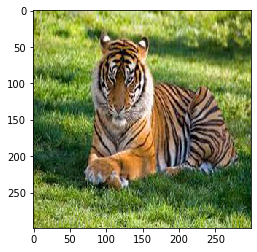

In [6]:
pil_img=Image.open(image_name)
pil_img=pil_img.resize((299,299), Image.ANTIALIAS)
# img.save('elephant.jpg')

plt.imshow(np.asarray(pil_img))

#### Transform image for classification

**Normalising and adding another dimension for matching models input shape**

In [0]:
img_transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),])
data=img_transform(pil_img).unsqueeze(0)

**Checking shape of the input**

In [8]:
data.size()

torch.Size([1, 3, 299, 299])

**Enabling Gradient calculation for data**

In [0]:
data=Variable(data,requires_grad=True)

### Predict and calculate loss

#### Predict 

In [0]:
pred=inception(data)
_, target = torch.max(pred, 1)

Loading the imagenet label json to show the actual class name.(optinal)

In [0]:
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

percentage = (torch.nn.functional.softmax(pred, dim=1)[0] * 100).detach().numpy()
for idx in percentage.argsort()[-3:][::-1]:
    print(idx,idx2label[idx],percentage[idx],idx)

101 tusker 36.716946 101
386 African_elephant 30.57543 386
385 Indian_elephant 17.824085 385


#### Calculating loss

In [13]:
loss = F.nll_loss(pred,target )
print(loss.item())

-10.212212562561035


In [0]:
loss.backward()
# Collect datagrad
data_grad = data.grad

### Generating segmentation

#### Generating mask

In [0]:
smap=data_grad.reshape((3,299,299)).detach().numpy() 

**Removing sign**

In [0]:
smap=np.abs(smap)

**Taking maximum along all channels**

In [0]:
sal=np.amax(smap,axis=0)

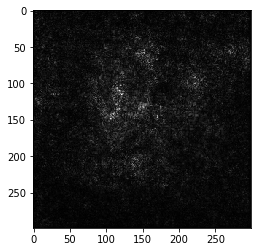

In [19]:
plt.imshow(sal, cmap='gray',vmin=np.min(sal), vmax=np.max(sal))

####**Threshold image using median value**
There can be lot of more starategies here like fixed threshold value

In [0]:
background_th,object_th=np.quantile(sal,[.70,.80])

In [0]:
mask=sal>object_th

In [0]:
mask=np.array(mask*255,dtype=np.uint8)

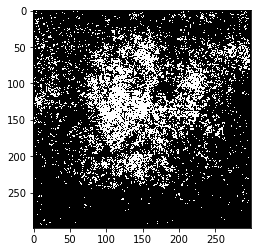

In [44]:
plt.imshow(mask, cmap='gray',vmin=0, vmax=255)

##### Generating bounding box

In [0]:
contours= cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]

In [0]:
img=np.asarray(pil_img)
img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

In [0]:
cnt=max(contours,key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt)

In [48]:
x, y, w, h

(70, 22, 128, 175)

In [0]:
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (x,y,x+w,y+h)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

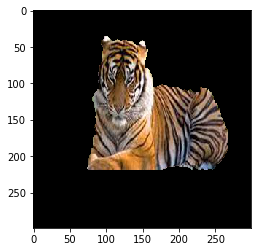

In [50]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()